# Comparison of asymptotically chisquare-distributed test statistics

This notebook is released under the MIT license. See LICENSE.

For GoF tests, we often use a test statistic that is asymptotically $\chi^2$ distributed.

We compute the test statistic on binned data with $k$ bins with Poisson-distributed counts $n_i$ for which we have estimates of the expected counts $\nu_i$, typically obtained from a fitted model with $m$ free parameters. If the data is truely sampled from the model (the $H_0$ hypothesis), the test statistic $X$ is asymptotically distributed as $\chi^2(k - m)$.

Small p-values $P = 1 - \int_{X}^\infty \chi^2(X'; k - m) \, \text{d}X'$ can be used as evidence against the hypothesis $H_0$.

Note: the asymptotic limit is assumed to be taken while keeping the binning constant. If the binning is adaptive to the sample size so that $\nu_i$ remains constant, $X$ will *not* approach the $\chi^2(k - m)$ distribution.

There are candidates for an asymptotically $\chi^2$-distributed test statistic.

* Pearson's test statistic
  $$X_P = \sum_i \frac{(n_i - \nu_i)^2}{\nu_i}$$

* Pearson's test statistic with $\nu_i$ replaced by bin-wise estimate $n_i$
  $$X_N = \sum_i \frac{(n_i - \nu_i)^2}{n_i}$$
  
* Likelihood ratio to saturated model (see e.g. introduction of https://doi.org/10.1088/1748-0221/4/10/P10009)
  $$X_{L} = 2\sum_i \Big( n_i \ln\frac{n_i}{\nu_i} - n_i + \nu_i \Big) $$
  
Given this choice, it is fair to ask which test statistic should be recommended for general use. The statistics may approach the $\chi^2(k - m)$ distribution with different speeds.

We check this empirically with toy simulations. For each experiment, we use a fixed expected value $\nu_i = \mu$ and draw $k$ Poisson-distributed numbers $n_i$ from $\mu$, corresponding to $k$ bins, each with $\nu_i = \mu$. We then compute the test statistics $X$ and its p-value, assuming it is $\chi^2(k)$ distributed ($m = 0$ here). This is repeated many times to get a histogram of p-values. The distribution is uniform if the test statistic $X$ is indeed $\chi^2(k)$ distributed. Deviations from uniformity indicate that the test statistic has not reached the asymptotic limit yet.

We then quantify the agreement of the p-value distribution with a flat distribution with the reduced $\chi^2$ value, computed as $X_p/k'$, where $k'$ is the number of bins in the p-value histogram.

In [1]:
import numpy as np
import numba as nb
from scipy.stats import chi2
import matplotlib.pyplot as plt
from pyik.mplext import plot_hist

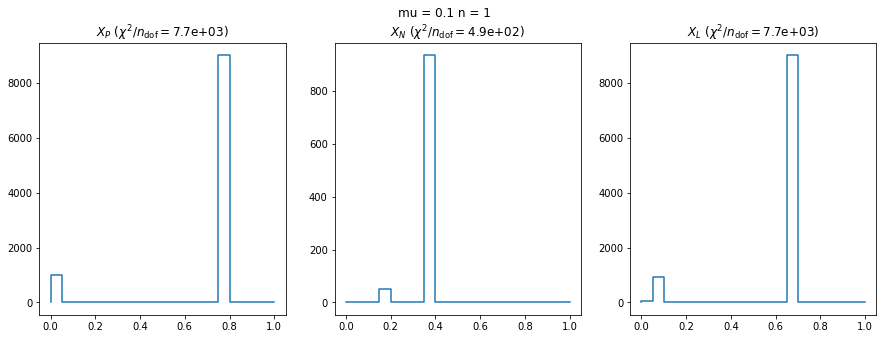

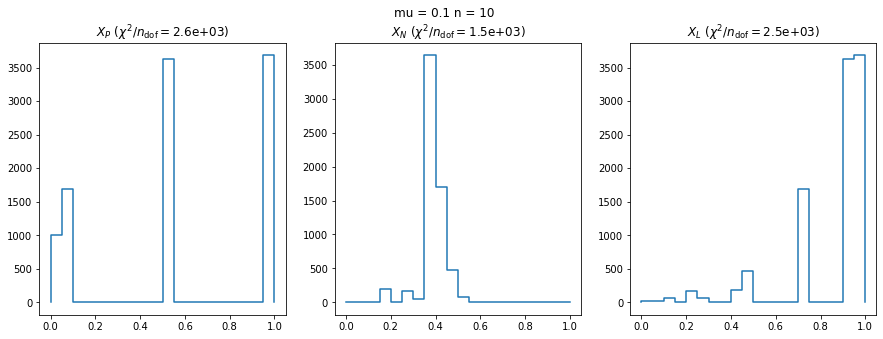

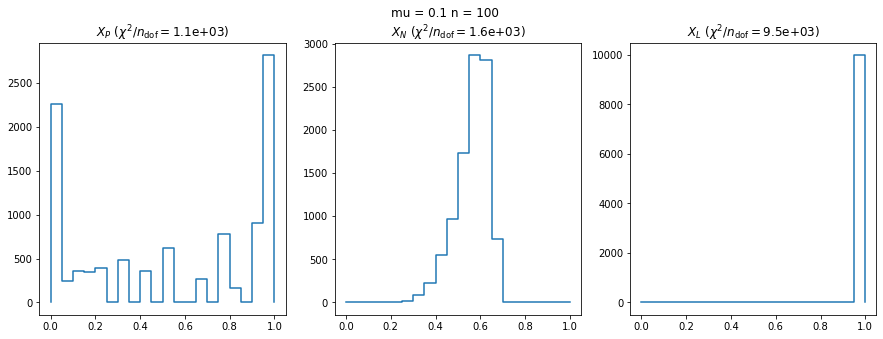

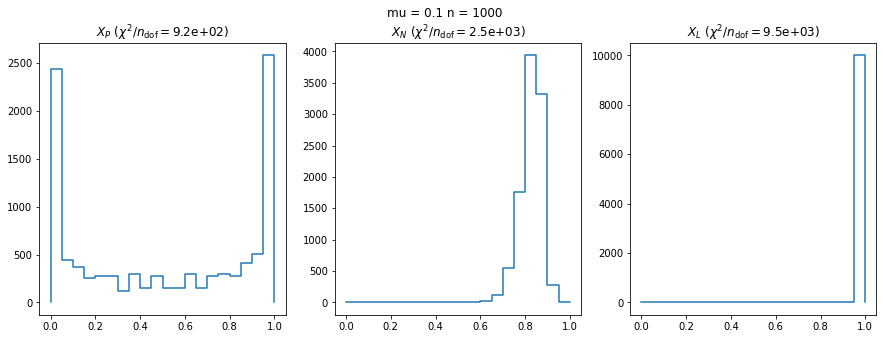

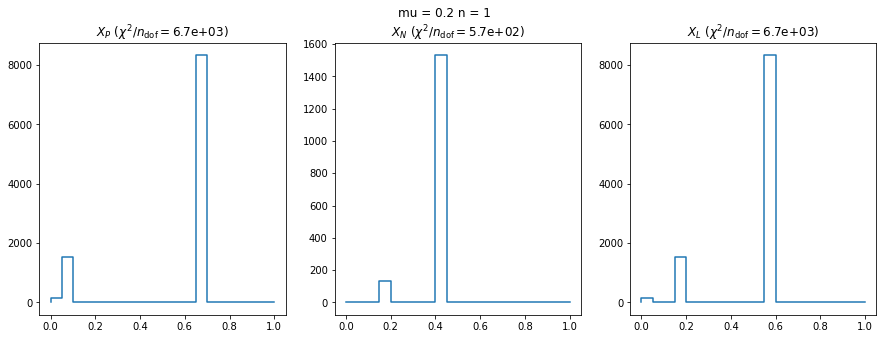

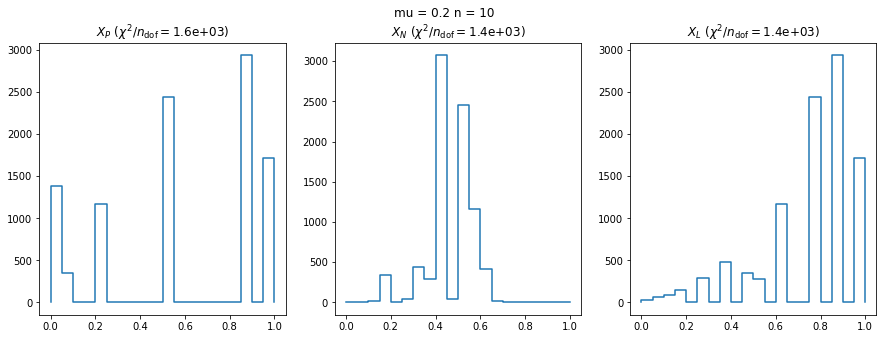

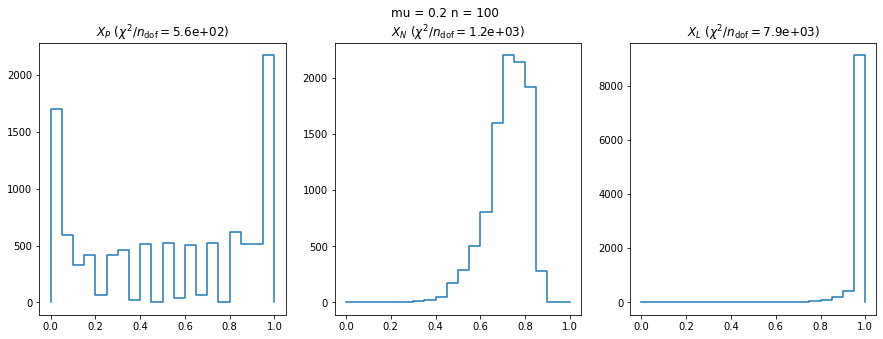

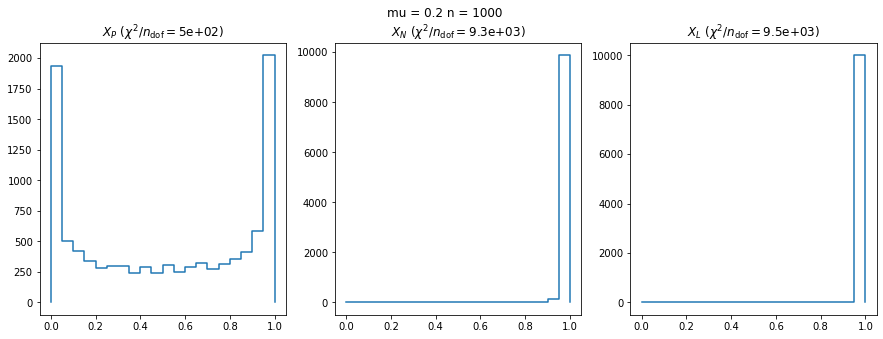

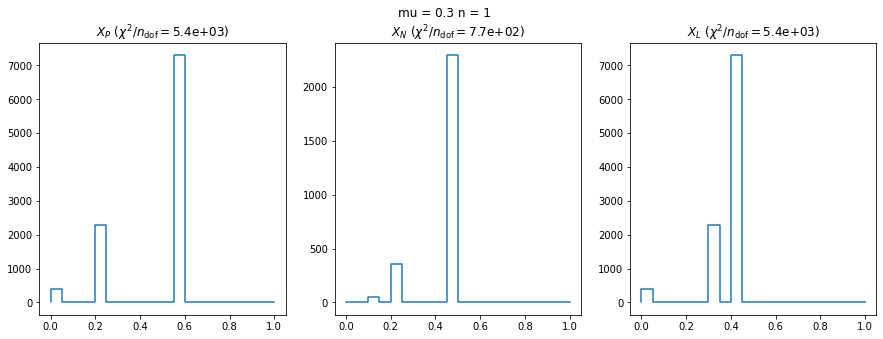

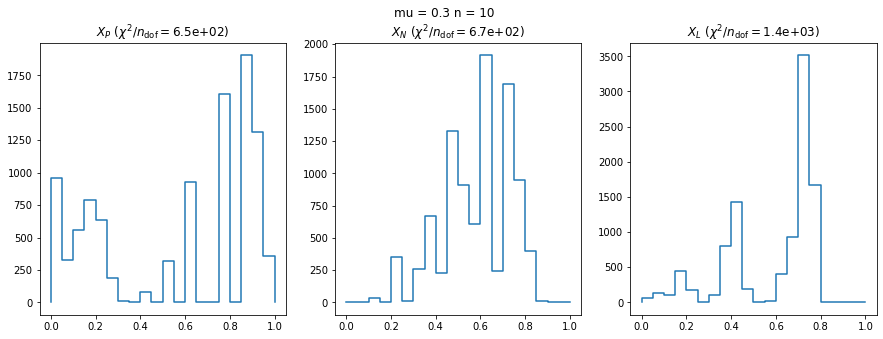

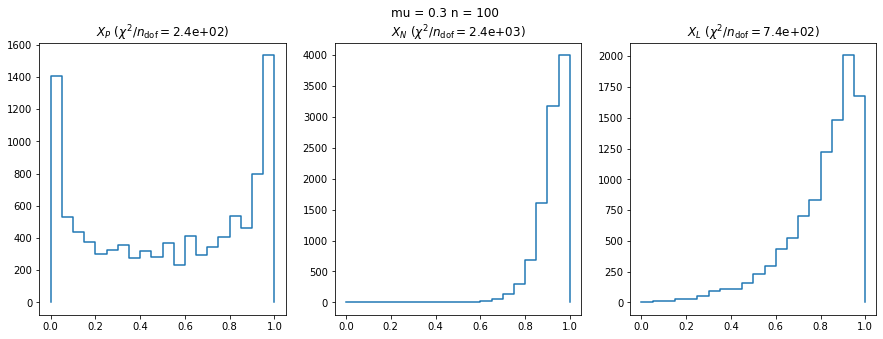

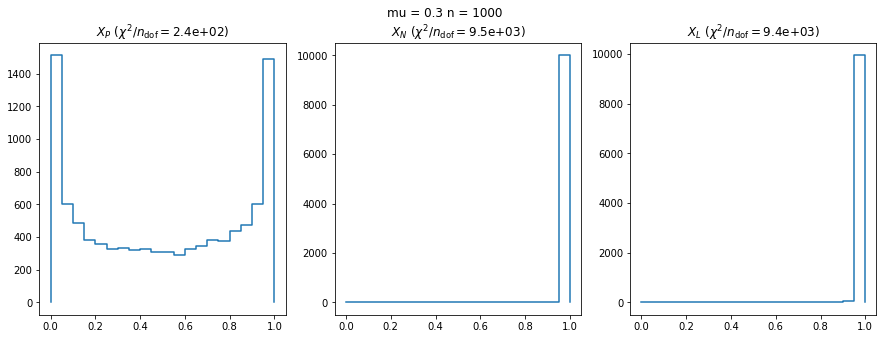

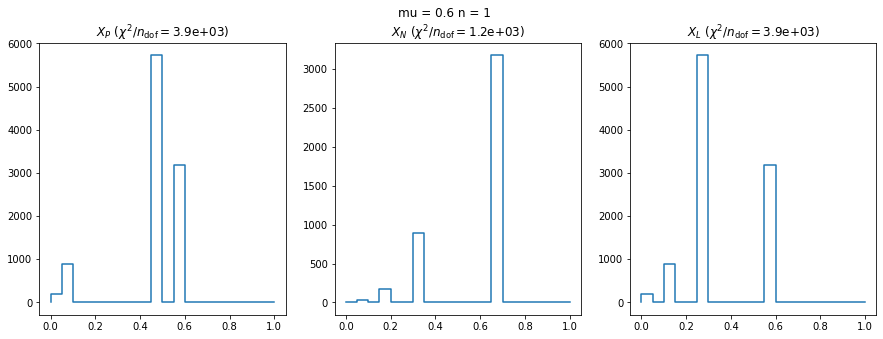

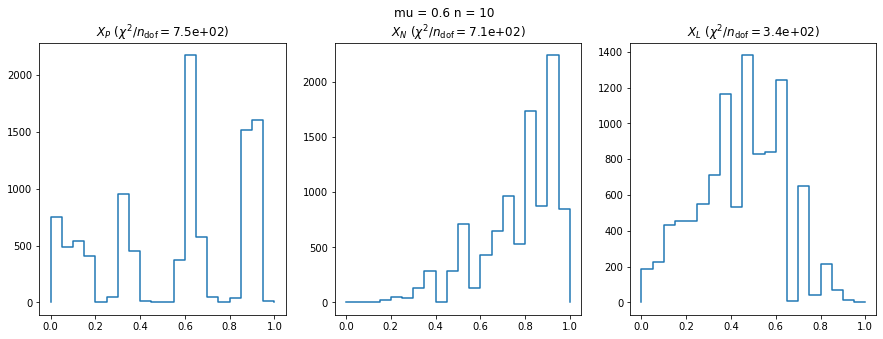

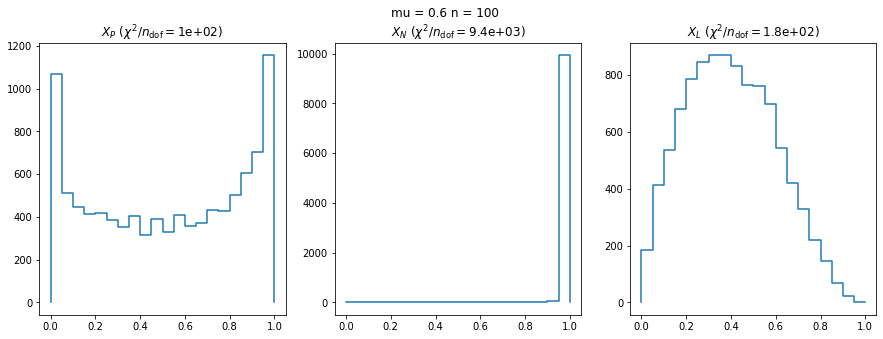

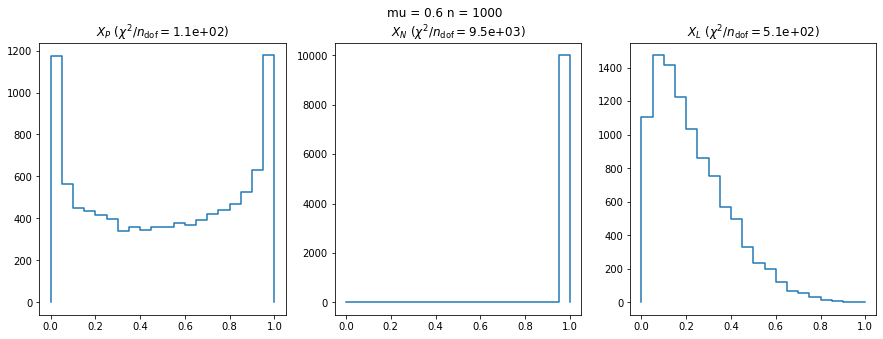

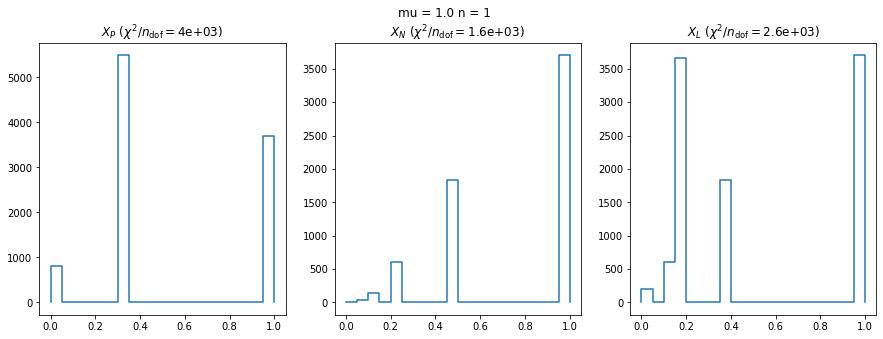

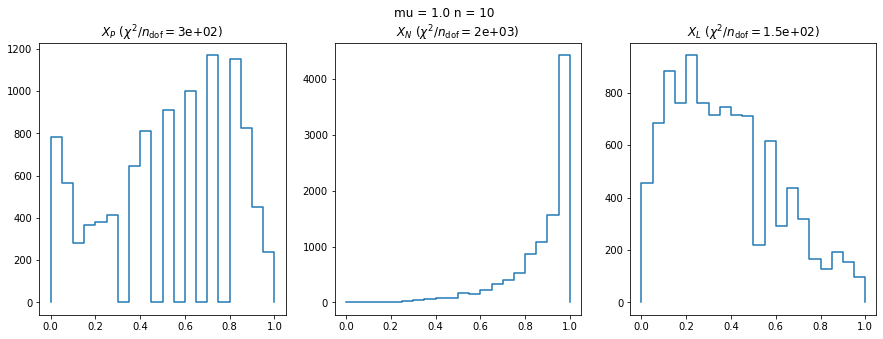

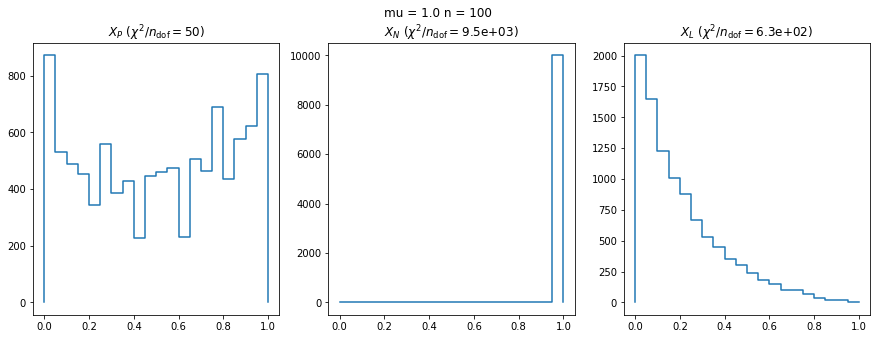

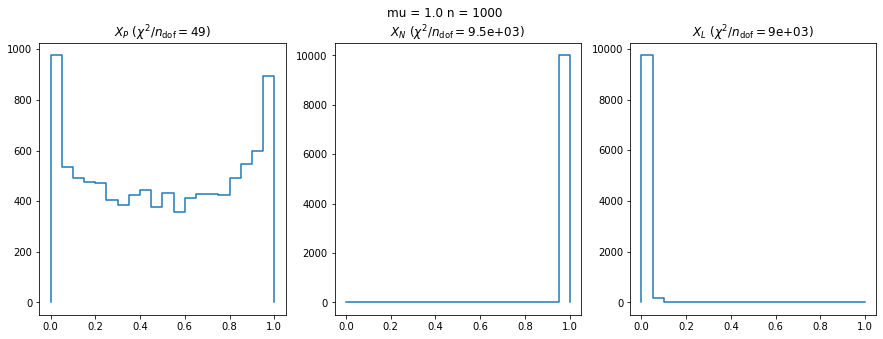

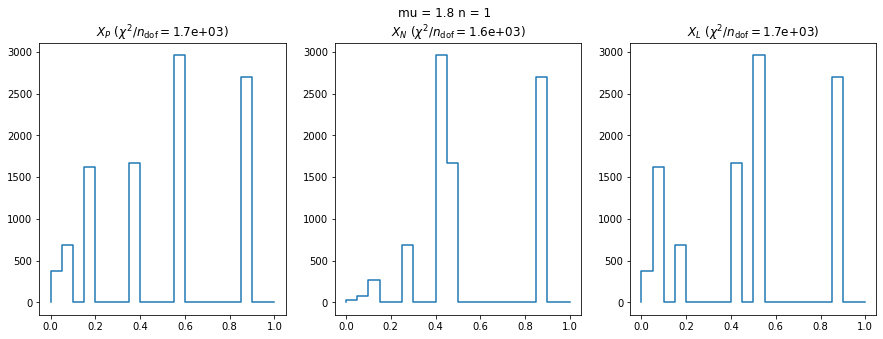

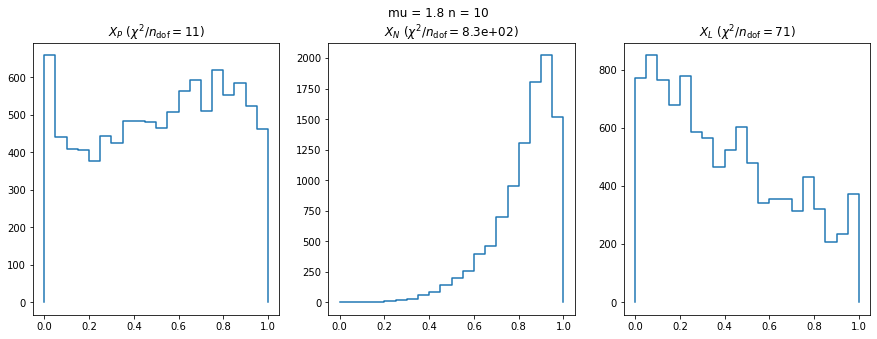

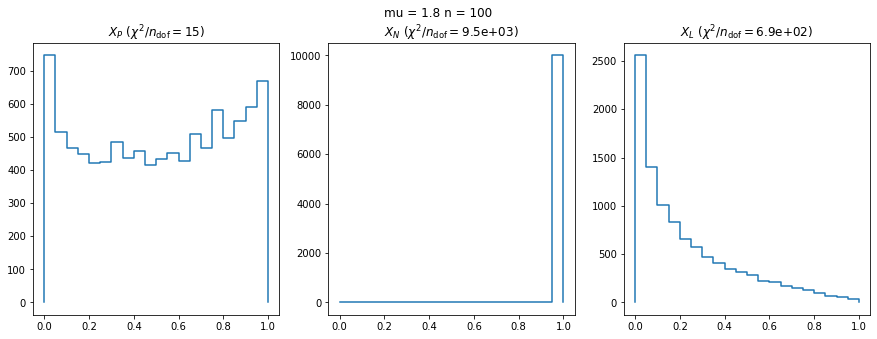

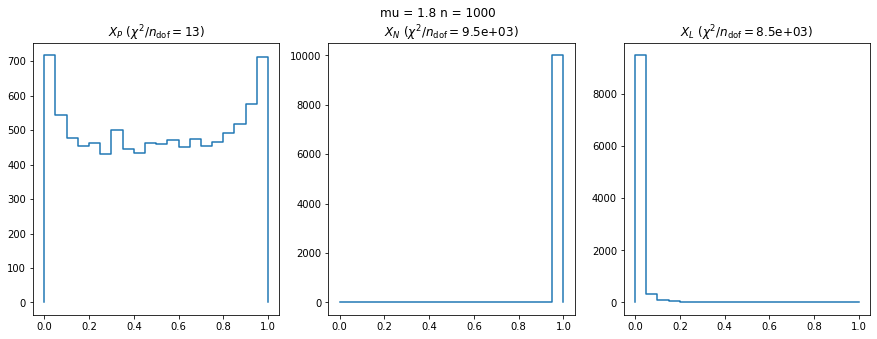

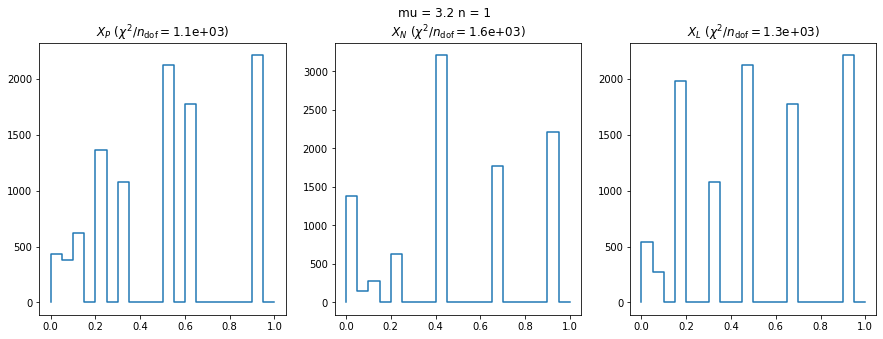

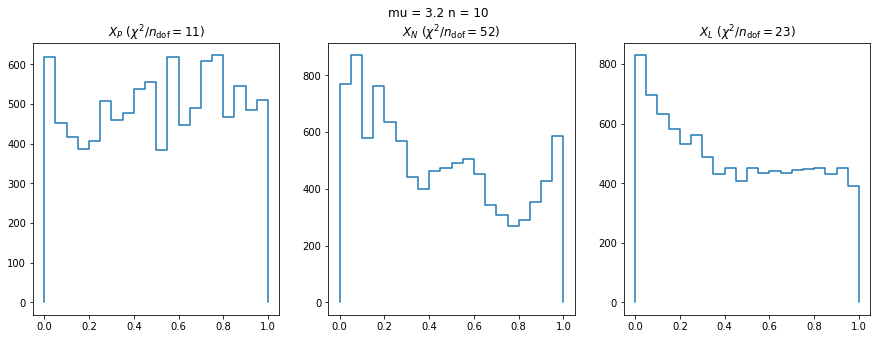

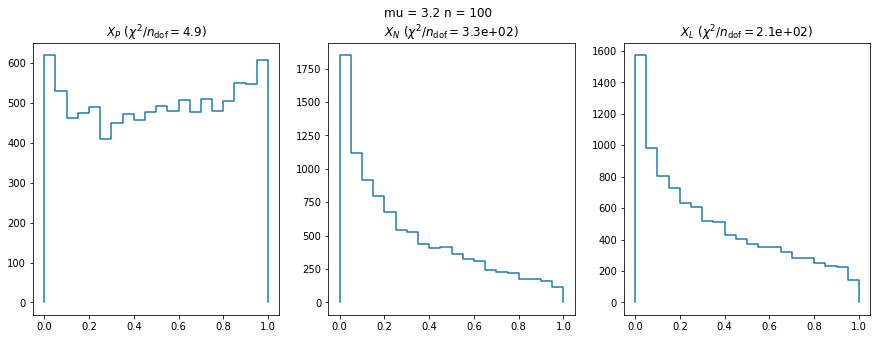

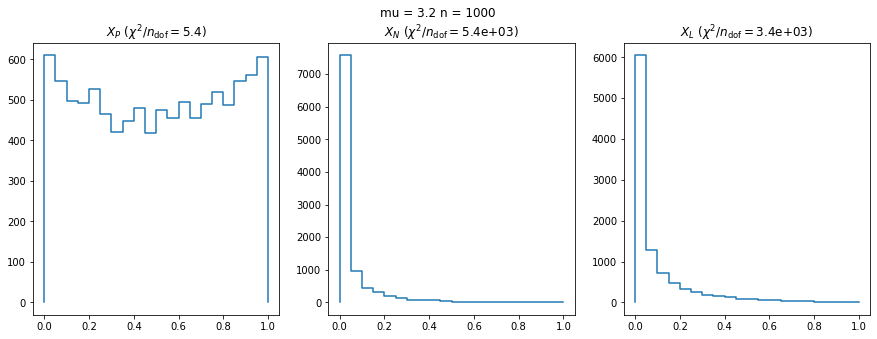

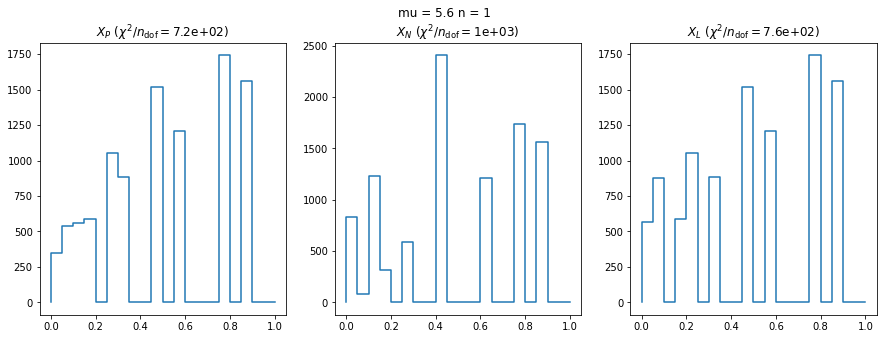

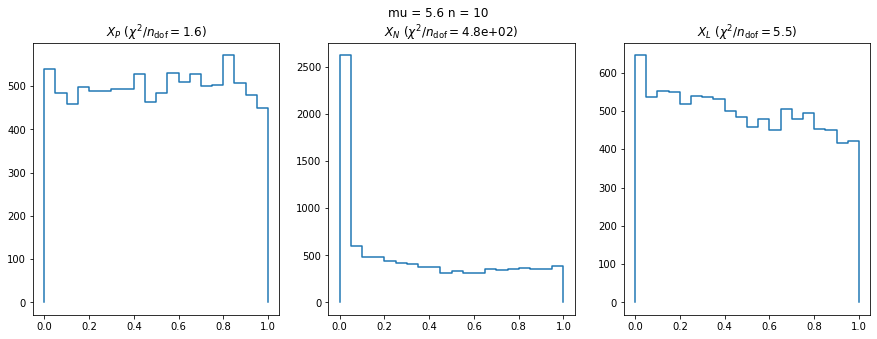

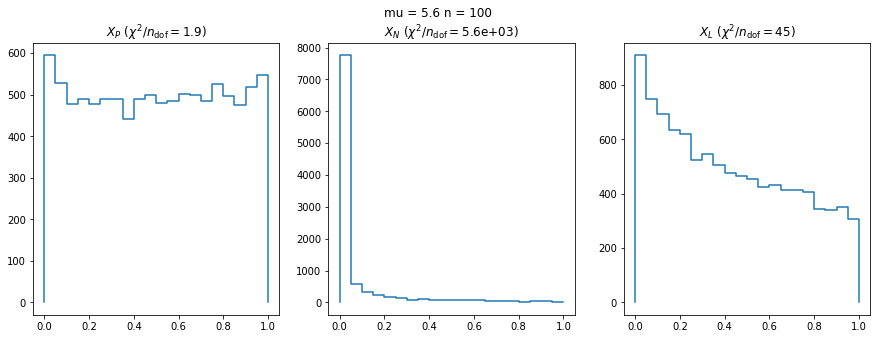

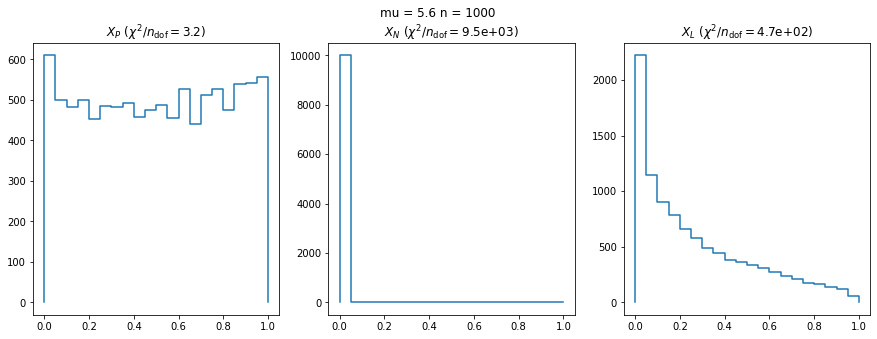

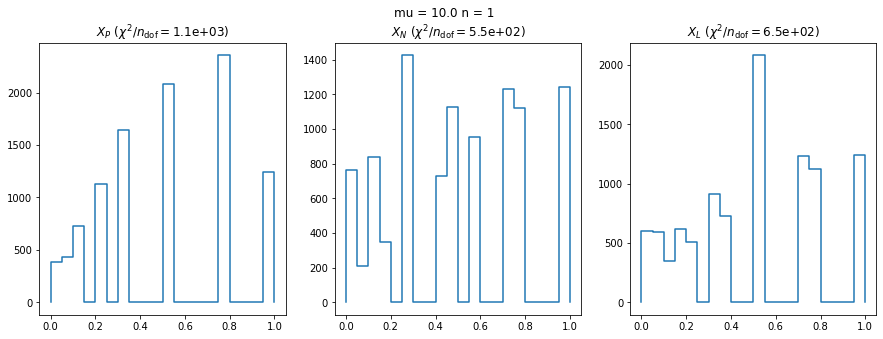

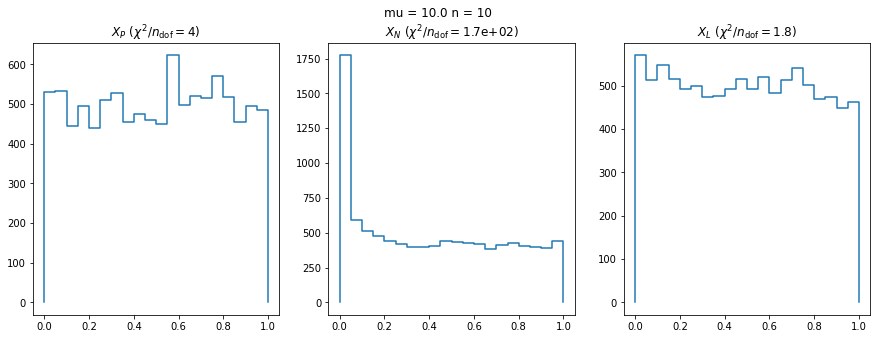

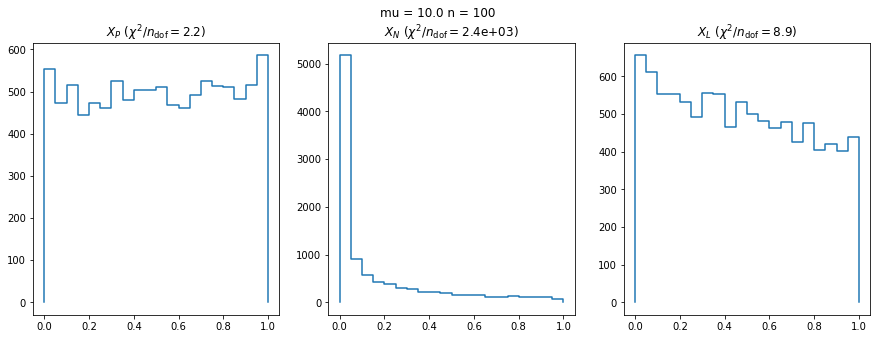

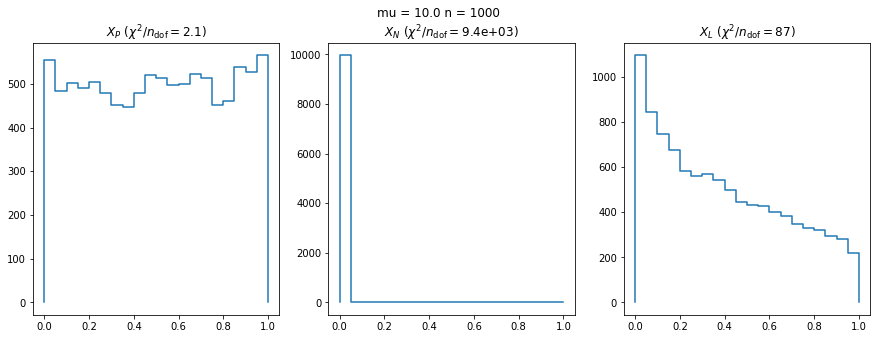

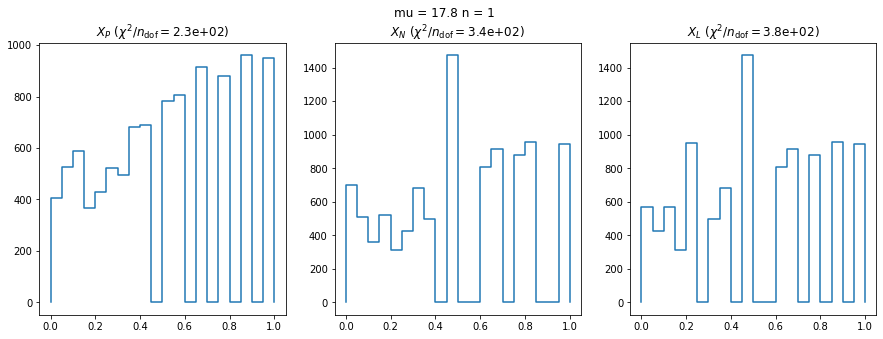

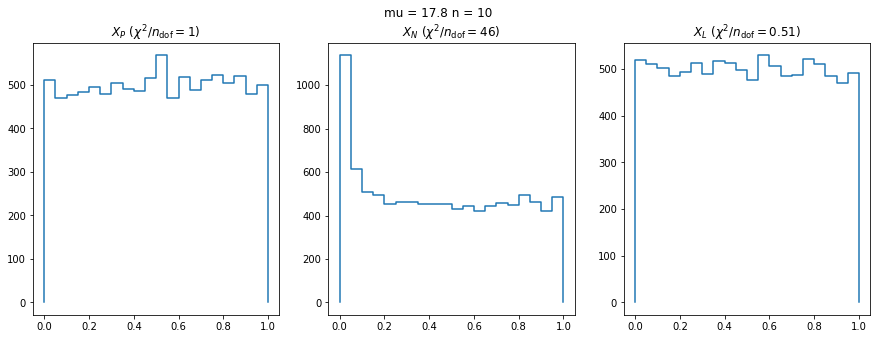

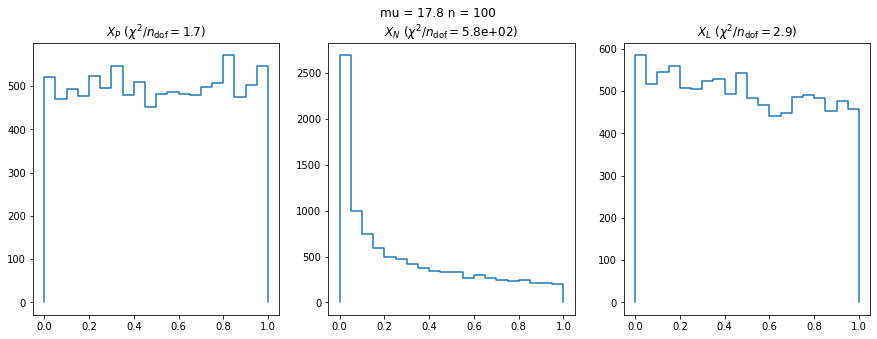

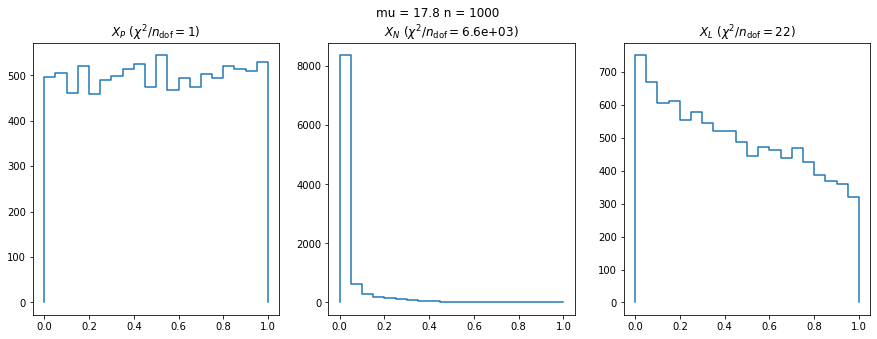

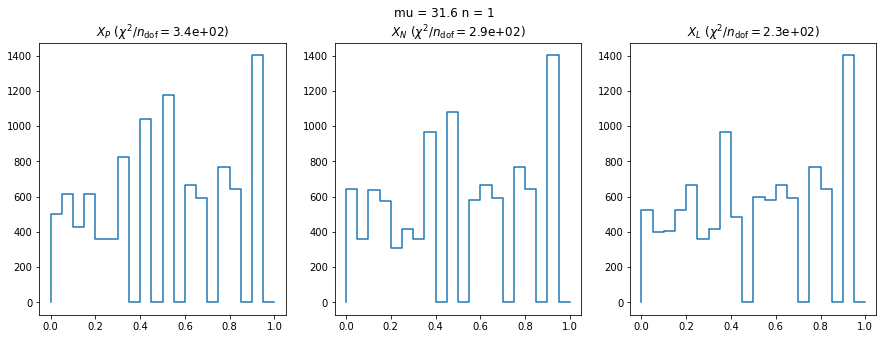

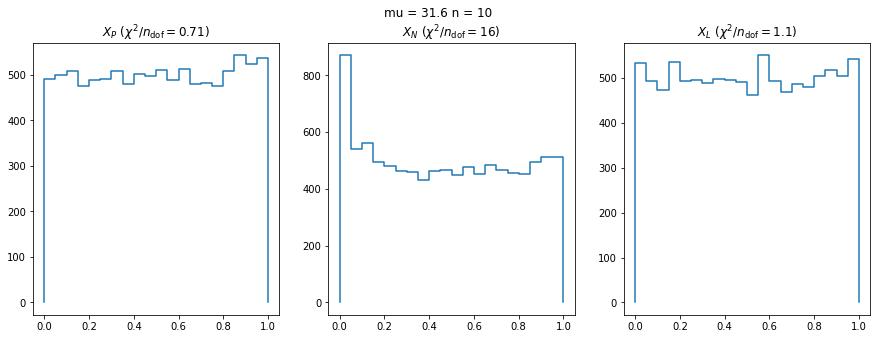

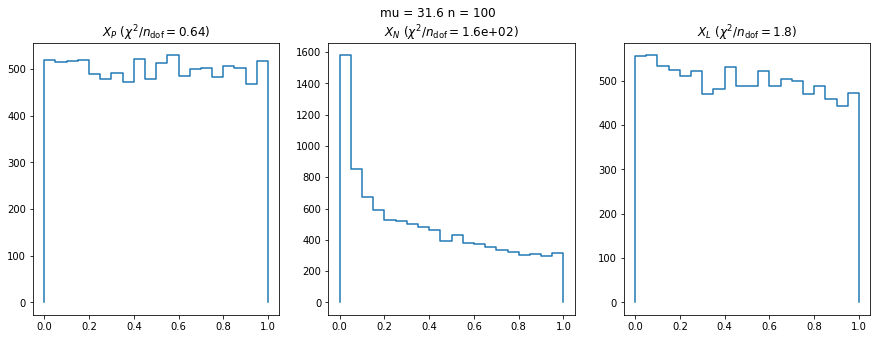

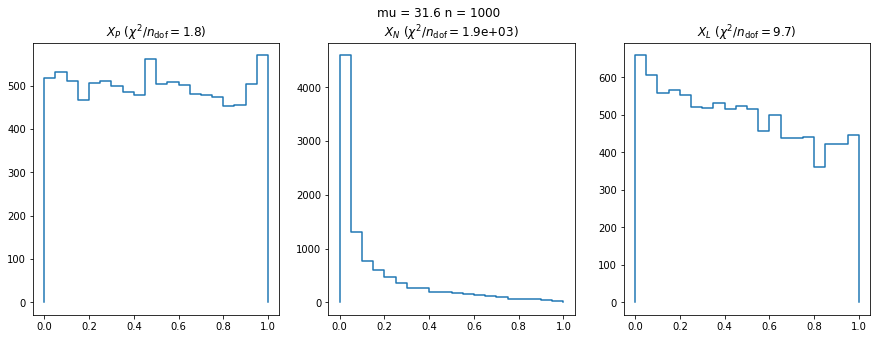

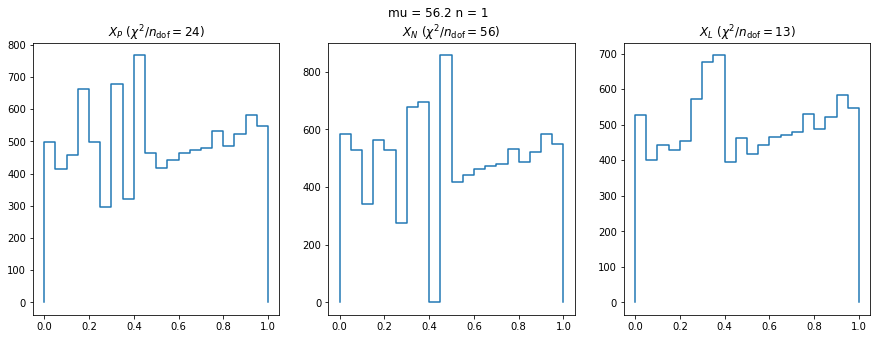

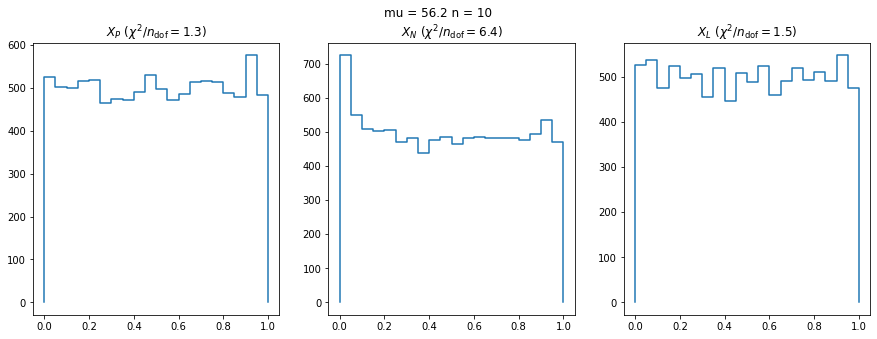

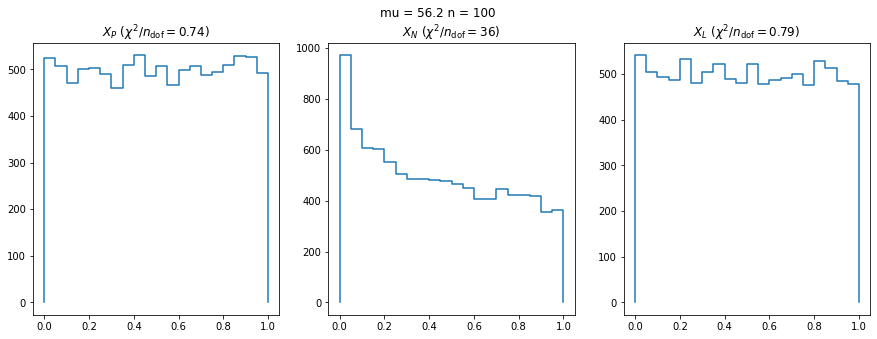

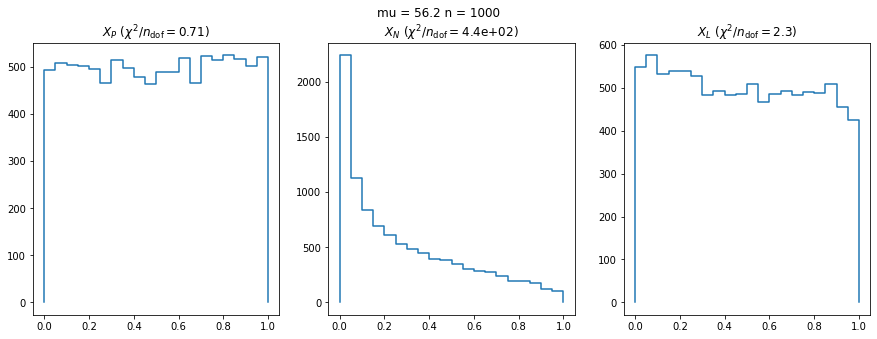

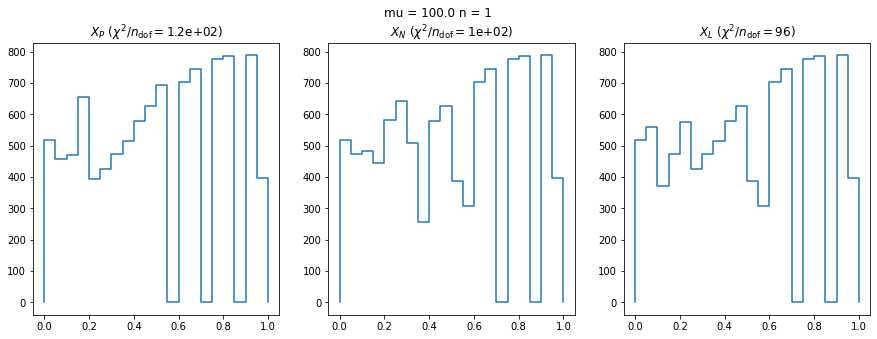

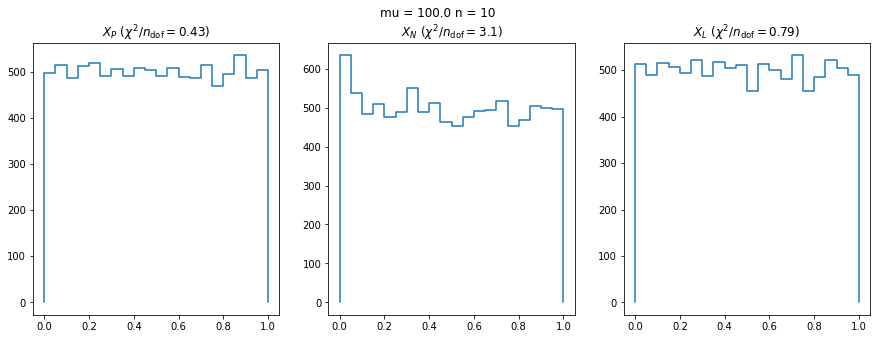

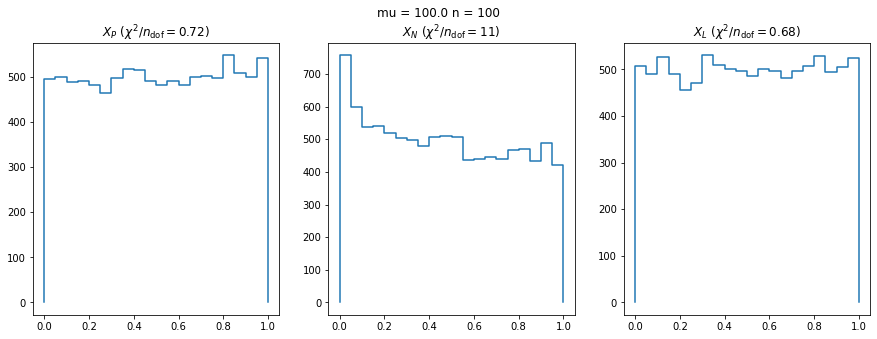

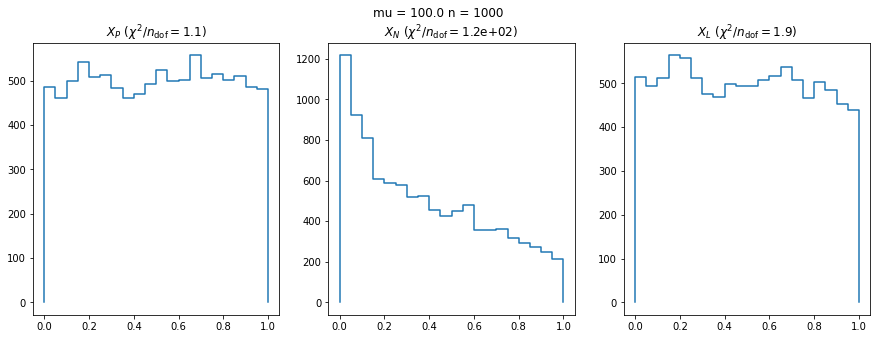

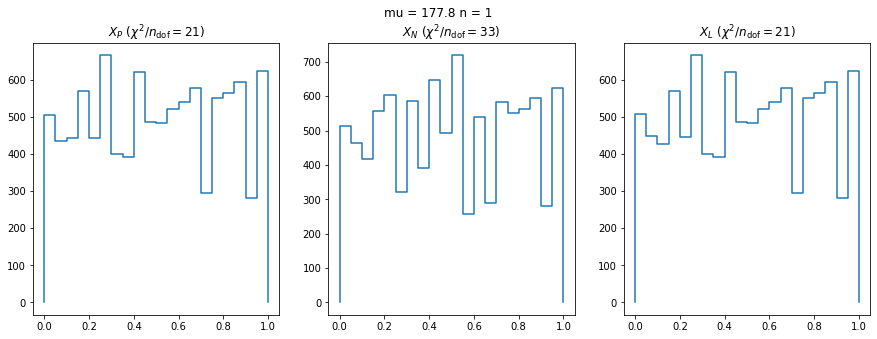

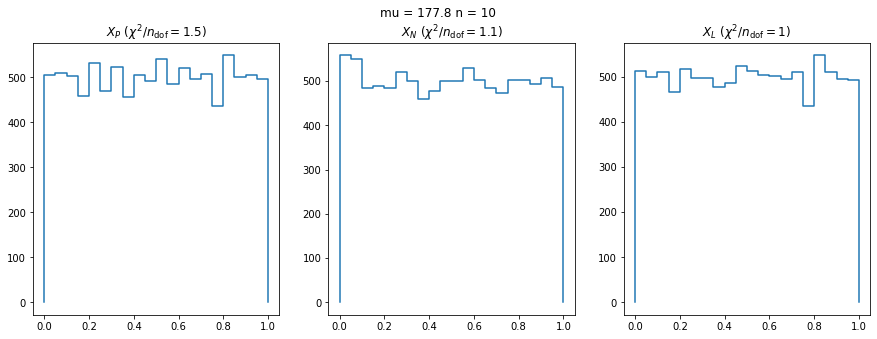

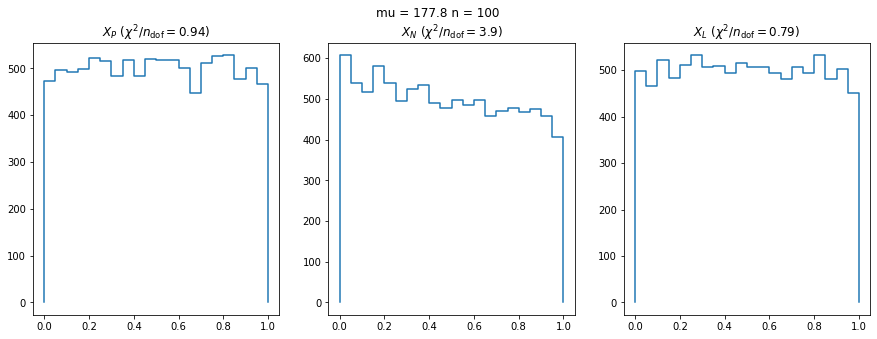

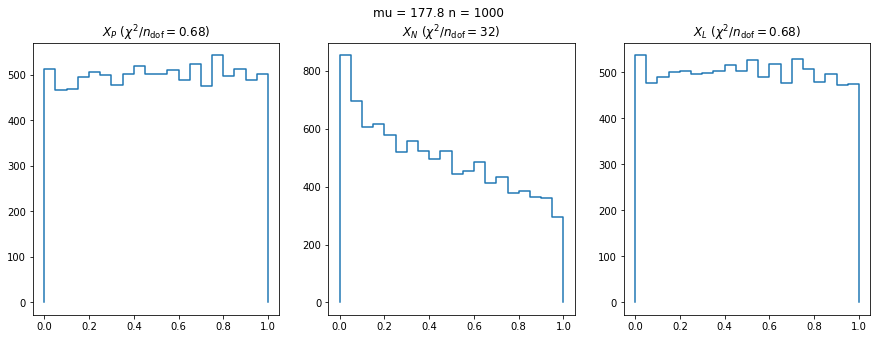

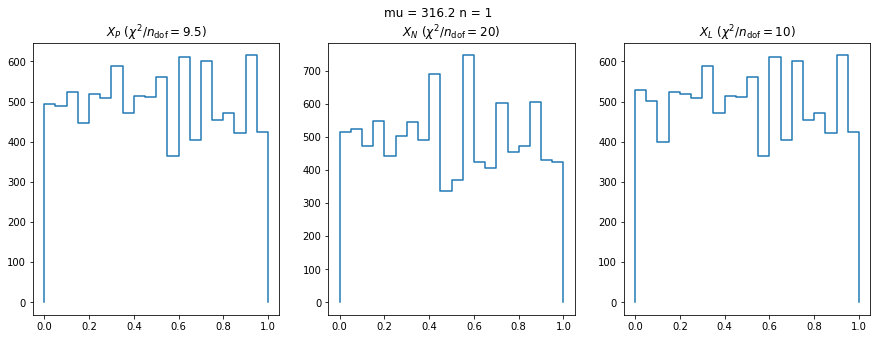

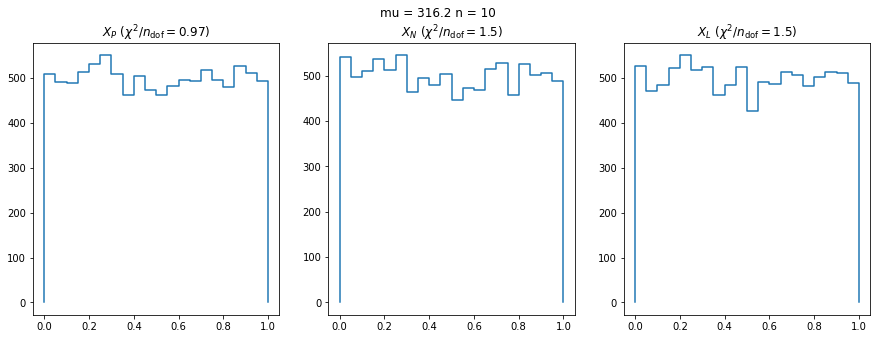

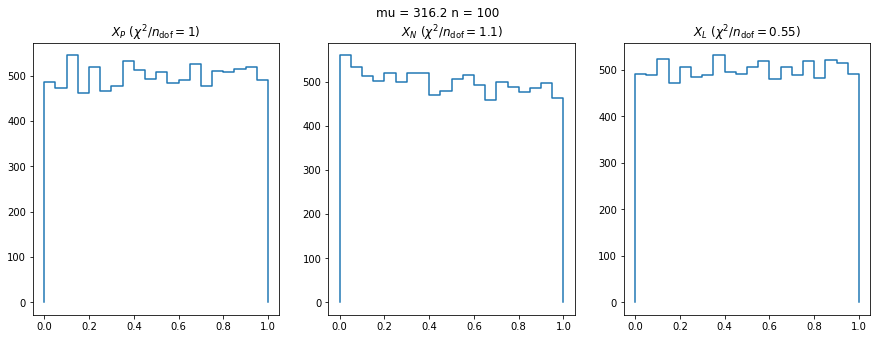

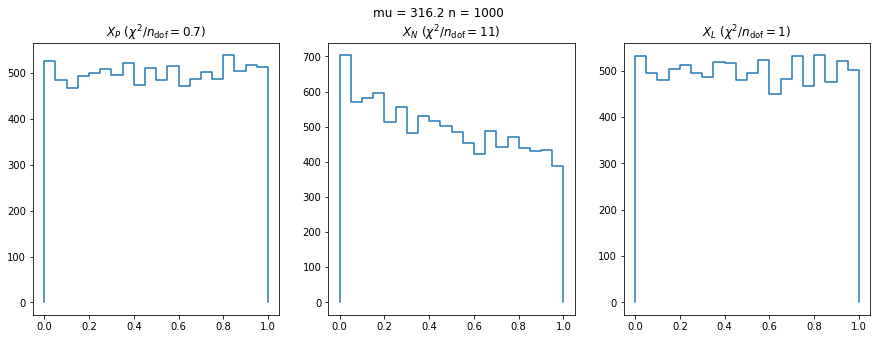

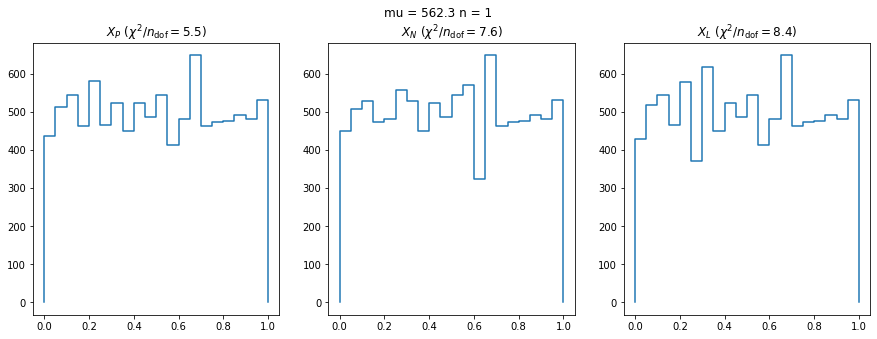

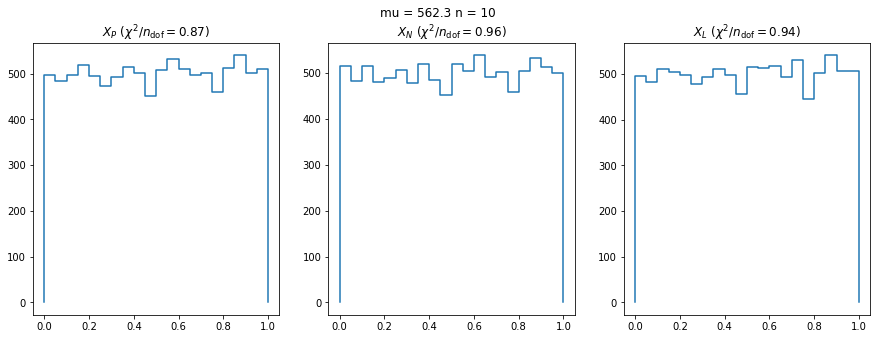

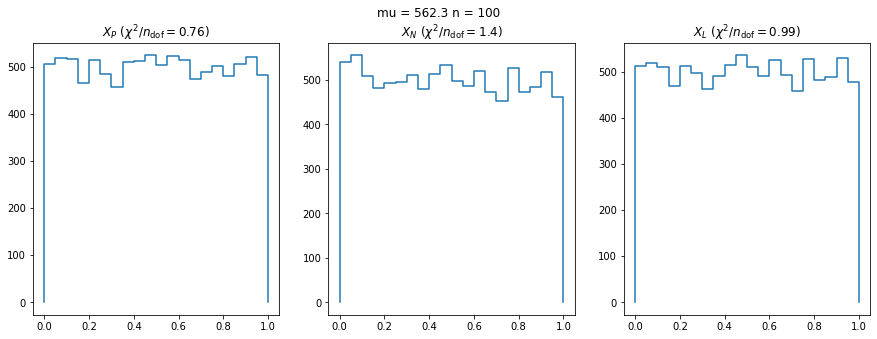

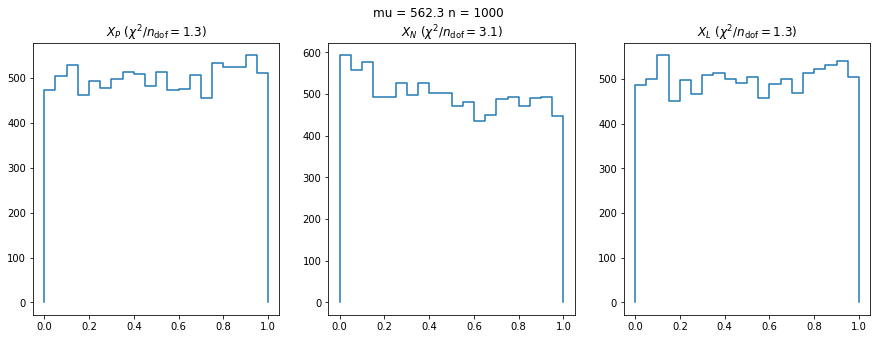

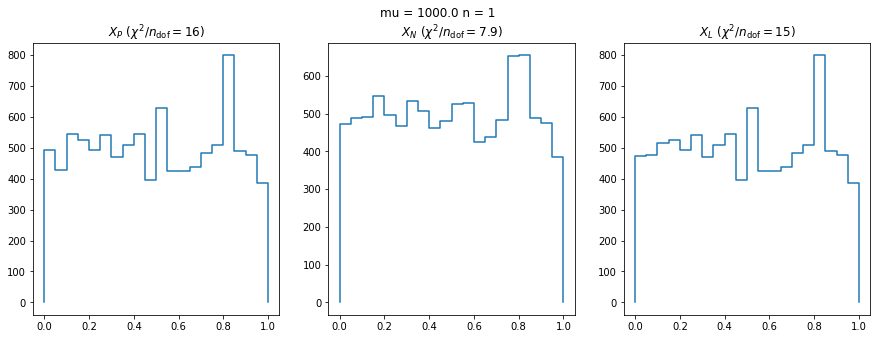

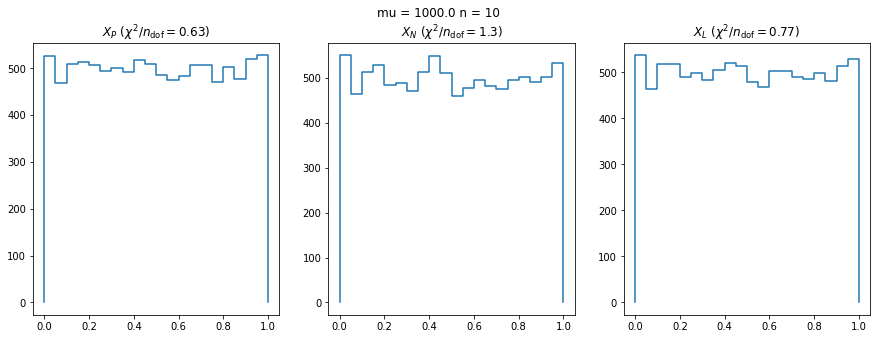

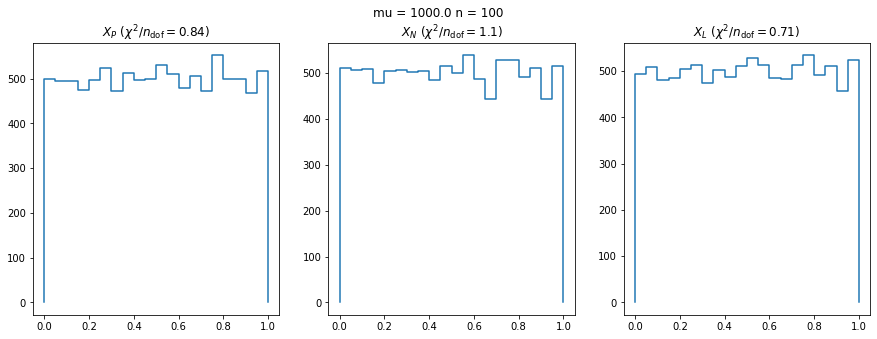

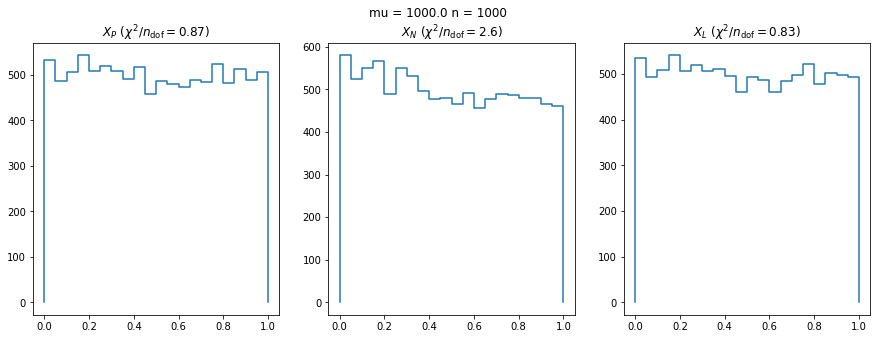

In [71]:
@nb.njit
def xn(n, v):
    r = 0.0
    k = 0
    for ni in n:
        if ni > 0:
            k += 1
            r += (ni - v) ** 2 / ni
    return r, k


def xp(n, v):
    return np.sum((n - v) ** 2 / v), len(n)


@nb.njit
def xl(n, v):
    r = 0.0
    for ni in n:
        if ni > 0:
            r += ni * np.log(ni / v) + v - ni
        else:
            r += v
    return 2 * r, len(n)


rng = np.random.default_rng(1)

mu = np.geomspace(1e-1, 1e3, 17)
# n = 2, 3, 4, 5, 6, 7, 8, 9, 10, 100, 1000
n = 1, 10, 100, 1000
nmc = 10000


def plot(ndf, c, **kwargs):
    p = 1 - chi2.cdf(*np.transpose(c))
    bins = 20
    xe = np.linspace(0, 1, bins + 1)
    n = np.histogram(p, bins=xe)[0]
    plot_hist(xe, n, **kwargs)
    v = len(p)/bins
    return np.sum((n - v) ** 2 / v) / bins


matrix_p = np.empty((len(mu), len(n)))
matrix_n = np.empty((len(mu), len(n)))
matrix_l = np.empty((len(mu), len(n)))
for i, mui in enumerate(mu):
    row = []
    for j, ni in enumerate(n):
        cn = []
        cp = []
        cl = []
        for imc in range(nmc):
            x = rng.poisson(mui, size=ni)
            cp.append(xp(x, mui))
            cn.append(xn(x, mui))
            cl.append(xl(x, mui))
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        plt.suptitle(f"mu = {mui:.1f} n = {ni}")
        plt.sca(ax[0])
        r = matrix_p[i, j] = plot(ni, cp)
        plt.title(f"$X_P$ ($\chi^2/n_\mathrm{{dof}} = ${r:.2g})")
        plt.sca(ax[1])
        r = matrix_n[i, j] = plot(ni, cn)
        plt.title(f"$X_N$ ($\chi^2/n_\mathrm{{dof}} = ${r:.2g})")
        plt.sca(ax[2])
        r = matrix_l[i, j] = plot(ni, cl)
        plt.title(f"$X_L$ ($\chi^2/n_\mathrm{{dof}} = ${r:.2g})")
        plt.show()

We can by eye that $X_P$ gives the best results. Its p-value distribution converges to a uniform distribution for lower values of $\mu$ and $n$ than the other two test statistics. We summarize this by plotting the reduced $\chi^2$ for flatness as a function of $\mu$ and $n$.

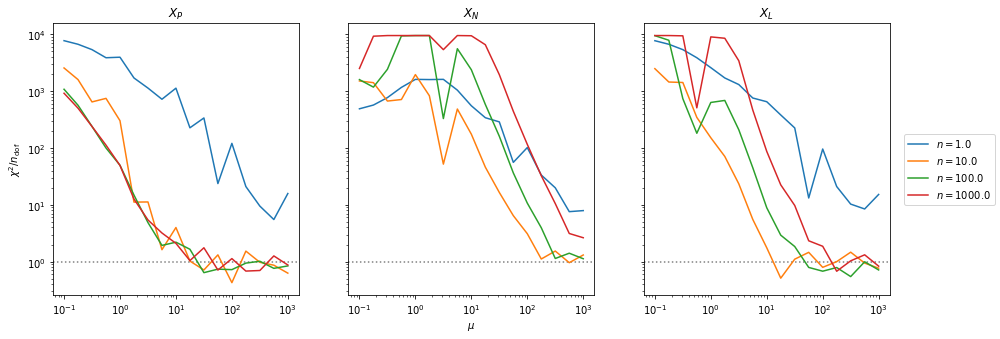

In [77]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
for i, ni in enumerate(n):
    for axi, matrix in zip(ax, (matrix_p, matrix_n, matrix_l)):
        axi.plot(mu, matrix[:, i],
                 label=f"$n = {ni:.1f}$" if matrix is matrix_p else None)

for axi, title in zip(ax, ("$X_P$", "$X_N$", "$X_L$")):
    axi.set_title(title)
    axi.axhline(1, ls=":", color="0.5", zorder=0)
ax[1].set_xlabel("$\mu$")
plt.figlegend(loc="center right")
ax[0].set_ylabel("$\chi^2 / n_\mathrm{dof}$")
plt.loglog();

The $X_P$ test statistic is clearly superior, it converges to the $\chi^2$ for smaller values of $\mu$ and $n$ than the other two.

The plots also confirm that none of the test statistics is doing well if the expected count per bin $\mu$ is smaller than about 10. If the original binned data contains bins with small counts, it is recommended to compute the distribution of the test statistic via parametric bootstrapping from the fitted model.

Parametric bootstrapping in this case simplifies to drawing new samples for each data bin from a Poisson distribution whose expectation is equal to the expected count per bin predicted by the model. For many such samples one computes the test statistic to obtain a distribution. The p-value is then given by the fraction of sample values that are higher than the original value.